In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import gaussian_blur
import random
from PIL import Image
import matplotlib.cm as cm
from captum.attr import IntegratedGradients
from pneumoniacnn import PneumoniaCNN
import utils as uti

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/Users/jolandamalamud/opt/miniconda3/envs/mlh_p2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
# Set paths
data_dir = '../data/chest_xray'
test_dir = os.path.join(data_dir, 'test')

# Define transforms
__, test_transform, viz_transform =  uti.transform_imgs()

# Load test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Dataset for visualization (without normalization)
viz_dataset = datasets.ImageFolder(root=test_dir, transform=viz_transform)

model = PneumoniaCNN()
model.to(device)

# Load the saved model
checkpoint = torch.load('cnn/pneumonia_cnn_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
class_names = checkpoint['class_names']
print("Loaded saved model successfully!")

# Set model to evaluation mode
model.eval()

Loaded saved model successfully!


PneumoniaCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [3]:
def baseline_image(baseline_name, input_tensor, dataset):
    if baseline_name == 'black':
        return torch.zeros_like(input_tensor)
    elif baseline_name == 'white':
        return torch.ones_like(input_tensor)
    elif baseline_name == 'grey':
        return torch.ones_like(input_tensor) * 0.5
    elif baseline_name == 'gauss':
        return gaussian_blur(input_tensor, kernel_size=[51, 51], sigma=[20, 20])
    elif baseline_name == 'average':
         
        dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    
        # Get all images in a single batch
        images, _ = next(iter(dataloader))

        return torch.mean(images, dim=0).unsqueeze(0)
        
def integrated_gradients_captum(model, inputs, target_class, steps=50, baseline=None):
    """
    Compute integrated gradients for a given input and target class using Captum.
    
    Args:
        model: The model to explain
        inputs: Input tensor
        target_class: Target class index
        steps: Number of steps in the Riemann approximation
        baseline: Baseline input (black image by default)
        
    Returns:
        Integrated gradients attribution map
    """
    # Set model to evaluation mode
    model.eval()
    
    # If no baseline provided, use a black image
    if baseline is None:
        baseline = torch.zeros_like(inputs)
    
    # Initialize Captum's IntegratedGradients
    ig = IntegratedGradients(model)
    
    # Define a target function that returns the output for the target class
    def target_function(input_tensor):
        return model(input_tensor)[:, target_class]
    
    # Compute attributions using Captum
    attributions = ig.attribute(
        inputs,
        baselines=baseline,
        target=target_class,
        n_steps=steps,
        method="riemann_trapezoid"  # More accurate integration method
    )
    
    # Sum over color channels
    attribution_map = attributions.sum(dim=1).squeeze()
    
    return attribution_map

In [4]:
# Function to visualize attribution maps
def visualize_attributions(img_tensor, attribution, original_img, title):
    """
    Visualize the input image and its attribution map.
    
    Args:
        img_tensor: Normalized input tensor
        attribution: Attribution map
        original_img: Original image for display
        title: Plot title
    """
    # Convert attribution to numpy and take absolute value
    attribution_np = attribution.cpu().detach().numpy()
    
    # Take absolute value to highlight both positive and negative attributions
    attribution_np = np.abs(attribution_np)
    
    # Normalize attributions for better visualization
    if attribution_np.max() != attribution_np.min():
        attribution_np = (attribution_np - attribution_np.min()) / (attribution_np.max() - attribution_np.min())
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Original X-ray')
    axes[0].axis('off')
    
    # Plot attribution map
    attribution_img = axes[1].imshow(attribution_np, cmap='hot')
    axes[1].set_title('Attribution Map')
    axes[1].axis('off')
    fig.colorbar(attribution_img, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Plot overlay of attribution on original image
    # Convert original image to RGB for overlay
    if len(original_img.shape) == 2:  # If grayscale
        original_img_rgb = np.stack([original_img] * 3, axis=2)
    else:  # If already RGB
        original_img_rgb = original_img
        
    # Normalize original image if needed
    if original_img_rgb.max() > 1.0:
        original_img_rgb = original_img_rgb / 255.0
    
    # Create heatmap
    heatmap = cm.jet(attribution_np)
    heatmap = heatmap[..., :3]  # Remove alpha channel
    
    # Create overlay with transparency
    alpha = 0.4
    overlay = original_img_rgb * (1 - alpha) + heatmap * alpha
    
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    return fig

In [5]:
# Main function to run integrated gradients analysis
def analyze_with_integrated_gradients(test_dataset, model, baseline_name='', figdir='attribution_maps'):
    
    # Get test examples
    # normal_indices, pneumonia_indices = uti.get_test_examples(test_dataset,5, 5)
    normal_indices, pneumonia_indices = uti.get_random_test_examples(test_dataset,5, 5, 42)

    
    # Process normal examples
    print("Processing normal examples...")
    for i, idx in enumerate(normal_indices):
        print(f"  Processing normal example {i+1}/5")
        
        # Get the image and label
        img_tensor, label = test_dataset[idx]
        img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension
        
        # Get original image for visualization
        # We'll use the visualization dataset to get the unnormalized image
        viz_img_tensor, _ = viz_dataset[idx]
        original_img = viz_img_tensor.permute(1, 2, 0).cpu().numpy()
        
        # If the image is RGB, convert to grayscale for display
        if original_img.shape[2] == 3:
            original_img = np.mean(original_img, axis=2)
        
        # Compute prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
            pred_prob = probs[0, pred_class].item()
        
        # Compute integrated gradients for the predicted class
        attributions = integrated_gradients_captum(model, img_tensor, pred_class, steps=50, \
                                                   baseline=baseline_image(baseline_name, img_tensor, test_dataset))
        
        # Visualize
        title = f"Normal X-ray #{idx} | Predicted: {class_names[pred_class]} ({pred_prob:.2f})"
        fig = visualize_attributions(img_tensor, attributions, original_img, title)
        
        # Save figure
        plt.savefig(os.path.join(figdir, f'normal_attribution_{i+1}_baseline_{baseline_name}.png'))
        plt.close(fig)
    
    # Process pneumonia examples
    print("Processing pneumonia examples...")
    for i, idx in enumerate(pneumonia_indices):
        print(f"  Processing pneumonia example {i+1}/5")
        
        # Get the image and label
        img_tensor, label = test_dataset[idx]
        img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension
        
        # Get original image for visualization
        viz_img_tensor, _ = viz_dataset[idx]
        original_img = viz_img_tensor.permute(1, 2, 0).cpu().numpy()
        
        # If the image is RGB, convert to grayscale for display
        if original_img.shape[2] == 3:
            original_img = np.mean(original_img, axis=2)
        
        # Compute prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
            pred_prob = probs[0, pred_class].item()
        
        # Compute integrated gradients for the predicted class
        attributions = integrated_gradients_captum(model, img_tensor, pred_class, steps=50, \
                                                   baseline=baseline_image(baseline_name, img_tensor, test_dataset))
        
        # Visualize
        title = f"Pneumonia X-ray #{idx} | Predicted: {class_names[pred_class]} ({pred_prob:.2f})"
        fig = visualize_attributions(img_tensor, attributions, original_img, title)
        
        # Save figure
        plt.savefig(os.path.join(figdir, f'pneumonia_attribution_{i+1}_baseline_{baseline_name}.png'))
        plt.close(fig)

    # Create a combined visualization of all examples
    print("Creating combined visualization...")
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    
    # Function to plot compact
    def plot_compact(ax, idx, row, col, is_normal=True):
        # Get image tensor
        img_tensor, _ = test_dataset[idx]
        img_tensor = img_tensor.unsqueeze(0).to(device)
        
        # Get original image for visualization
        viz_img_tensor, _ = viz_dataset[idx]
        original_img = viz_img_tensor.permute(1, 2, 0).cpu().numpy()
        
        # If the image is RGB, convert to grayscale for display
        if original_img.shape[2] == 3:
            original_img = np.mean(original_img, axis=2)
        
        # Get prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
            pred_prob = probs[0, pred_class].item()
        
        # Compute integrated gradients for the predicted class
        attributions = integrated_gradients_captum(model, img_tensor, pred_class, steps=50, \
                                               baseline=baseline_image(baseline_name, img_tensor, test_dataset))
        
        # Convert original image to RGB for overlay
        if len(original_img.shape) == 2:  # If grayscale
            original_img_rgb = np.stack([original_img] * 3, axis=2)
        else:  # If already RGB
            original_img_rgb = original_img
        
        # Normalize original image if needed
        if original_img_rgb.max() > 1.0:
            original_img_rgb = original_img_rgb / 255.0

        # Convert attribution to numpy and take absolute value
        attribution_np = attributions.cpu().detach().numpy()
        
        # Take absolute value to highlight both positive and negative attributions
        attribution_np = np.abs(attribution_np)
        
        # Normalize attributions for better visualization
        if attribution_np.max() != attribution_np.min():
            attribution_np = (attribution_np - attribution_np.min()) / (attribution_np.max() - attribution_np.min())
        
        # Create heatmap
        heatmap = cm.jet(attribution_np)
        heatmap = heatmap[..., :3]  # Remove alpha channel
        
        # Create overlay with transparency
        alpha = 0.5
        overlay = original_img_rgb * (1 - alpha) + heatmap * alpha
        
        # Plot
        ax.imshow(overlay)
        class_text = "Normal" if is_normal else "Pneumonia"
        ax.set_title(f"{class_text} #{col+1} | Pred: {class_names[pred_class]} ({pred_prob:.2f})")
        ax.axis('off')

    # Plot pneumonia examples
    for i, idx in enumerate(pneumonia_indices):
        plot_compact(axes[0, i], idx, 1, i, is_normal=False)
    
    # Plot normal examples
    for i, idx in enumerate(normal_indices):
        plot_compact(axes[1, i], idx, 0, i, is_normal=True)
    
    plt.suptitle("Integrated-Gradients Attribution Maps", fontsize=20)
    plt.tight_layout()
    plt.savefig(figdir + '/all_attributionmaps_baseline_' + baseline_name + '.png')
    plt.close()
    
    print("Int-Grad analysis complete. Results saved in " + figdir + " folder.")

In [6]:
figdir="figs/attribution_maps"
os.makedirs(figdir, exist_ok=True)
# Run the analysis
for i in ['black', 'white', 'grey', 'gauss', 'average']:
    analyze_with_integrated_gradients(test_dataset, model, baseline_name=i, figdir=figdir)

Found 234 normal samples and 390 pneumonia samples
Selected normal indices: [163, 28, 6, 189, 70]
Selected pneumonia indices: [359, 348, 305, 611, 286]
Processing normal examples...
  Processing normal example 1/5
  Processing normal example 2/5
  Processing normal example 3/5
  Processing normal example 4/5
  Processing normal example 5/5
Processing pneumonia examples...
  Processing pneumonia example 1/5
  Processing pneumonia example 2/5
  Processing pneumonia example 3/5
  Processing pneumonia example 4/5
  Processing pneumonia example 5/5
Creating combined visualization...
Int-Grad analysis complete. Results saved in figs/attribution_maps folder.
Found 234 normal samples and 390 pneumonia samples
Selected normal indices: [163, 28, 6, 189, 70]
Selected pneumonia indices: [359, 348, 305, 611, 286]
Processing normal examples...
  Processing normal example 1/5
  Processing normal example 2/5
  Processing normal example 3/5
  Processing normal example 4/5
  Processing normal example 5/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].


  Processing normal example 3/5
  Processing normal example 4/5
  Processing normal example 5/5
Processing pneumonia examples...
  Processing pneumonia example 1/5
  Processing pneumonia example 2/5
  Processing pneumonia example 3/5
  Processing pneumonia example 4/5
  Processing pneumonia example 5/5
Creating combined visualization...
Int-Grad analysis complete. Results saved in figs/attribution_maps folder.
Found 234 normal samples and 390 pneumonia samples
Selected normal indices: [163, 28, 6, 189, 70]
Selected pneumonia indices: [359, 348, 305, 611, 286]
Processing normal examples...
  Processing normal example 1/5
  Processing normal example 2/5
  Processing normal example 3/5
  Processing normal example 4/5
  Processing normal example 5/5
Processing pneumonia examples...
  Processing pneumonia example 1/5
  Processing pneumonia example 2/5
  Processing pneumonia example 3/5
  Processing pneumonia example 4/5
  Processing pneumonia example 5/5
Creating combined visualization...
I

Integrated Gradient with randomized model
---

In [7]:
# Load randomized model
randomized_model = PneumoniaCNN()
randomized_model.to(device)

# Load the saved model
checkpoint = torch.load('cnn/randomized_pneumonia_model.pth', map_location=device)
randomized_model.load_state_dict(checkpoint['model_state_dict'])
print("Loaded randomized model successfully!")
    
# Create directory for saving figures
os.makedirs("figs/attribution_maps_rand", exist_ok=True)
analyze_with_integrated_gradients(test_dataset, randomized_model, baseline_name='black', figdir="figs/attribution_maps_rand")

Loaded randomized model successfully!
Found 234 normal samples and 390 pneumonia samples
Selected normal indices: [163, 28, 6, 189, 70]
Selected pneumonia indices: [359, 348, 305, 611, 286]
Processing normal examples...
  Processing normal example 1/5
  Processing normal example 2/5
  Processing normal example 3/5
  Processing normal example 4/5
  Processing normal example 5/5
Processing pneumonia examples...
  Processing pneumonia example 1/5
  Processing pneumonia example 2/5
  Processing pneumonia example 3/5
  Processing pneumonia example 4/5
  Processing pneumonia example 5/5
Creating combined visualization...
Int-Grad analysis complete. Results saved in figs/attribution_maps_rand folder.


Missclassification
---

Found 3 misclassified examples


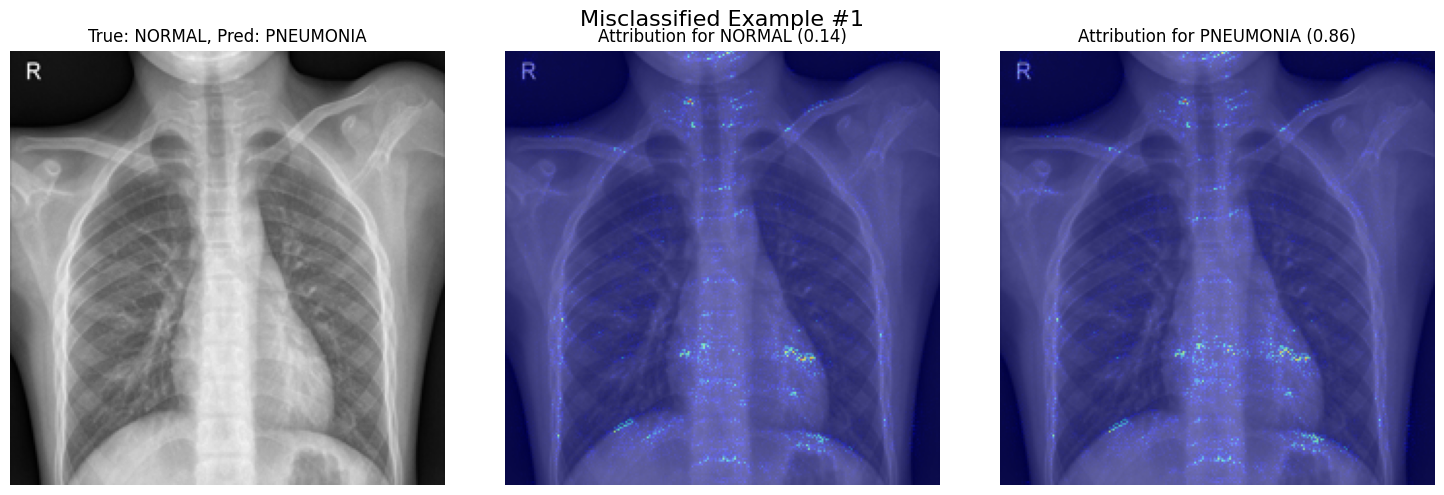

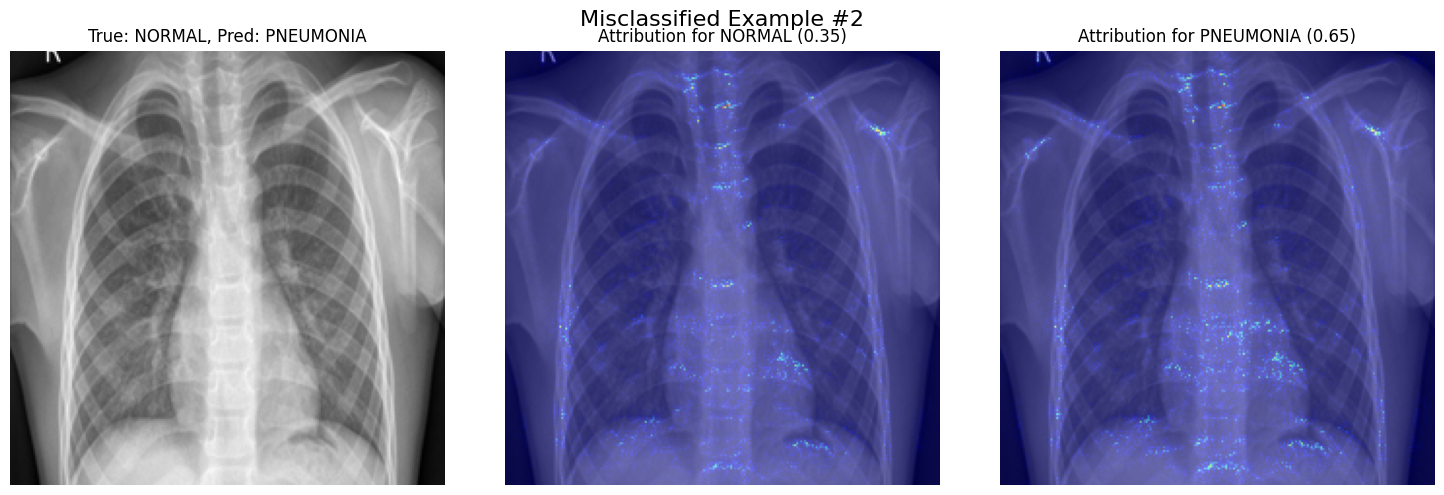

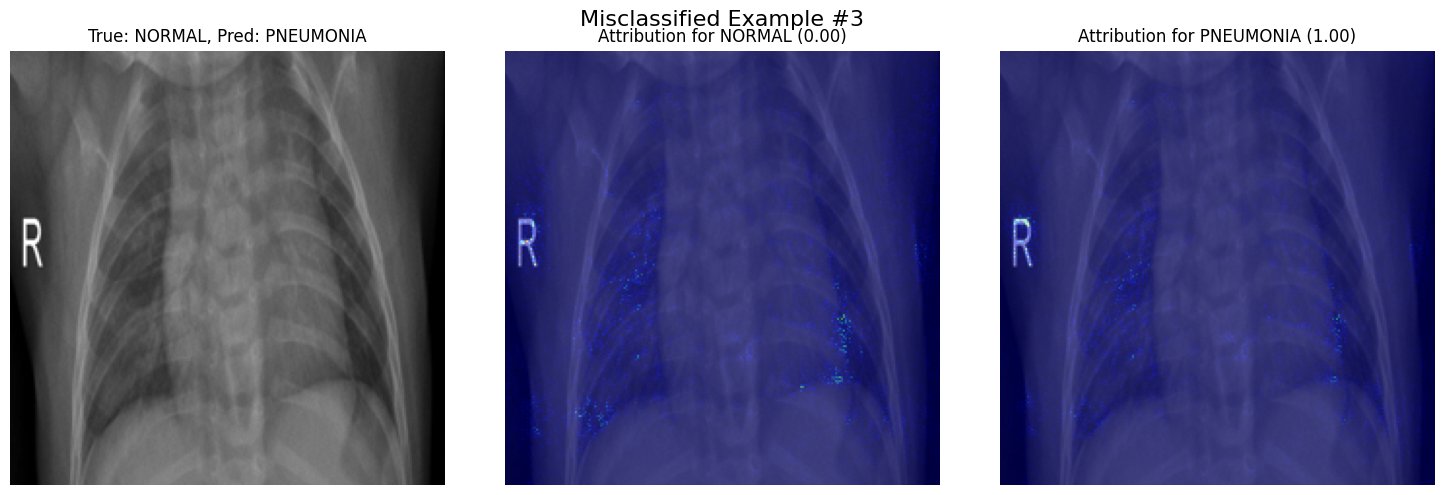

In [8]:
# Additional analysis: Compare attributions for correct and incorrect predictions
def analyze_misclassifications():
    baseline_name = 'black'
    # Find some misclassified examples
    misclassified_indices = []
    for i, (img_tensor, label) in enumerate(test_loader):
        img_tensor = img_tensor.to(device)
        
        # Get prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            _, preds = torch.max(outputs, 1)
        
        # Check if misclassified
        if preds.item() != label.item() and len(misclassified_indices) < 3:
            misclassified_indices.append(i)
        
        if len(misclassified_indices) >= 3:
            break
    
    # If we found misclassified examples, analyze them
    if misclassified_indices:
        print(f"Found {len(misclassified_indices)} misclassified examples")
        
        for i, idx in enumerate(misclassified_indices):
            # Get the image and label
            img_tensor, label = test_dataset[idx]
            img_tensor = img_tensor.unsqueeze(0).to(device)
            
            # Get the original image for display
            img_path = test_dataset.imgs[idx][0]
            original_img = Image.open(img_path).convert('L')
            original_img = original_img.resize((224, 224))
            original_img_np = np.array(original_img)
            
            # Get prediction
            with torch.no_grad():
                outputs = model(img_tensor)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                pred_class = torch.argmax(probs, dim=1).item()
                pred_prob = probs[0, pred_class].item()
            
            # Create figure to show attributions for both classes
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Plot original image
            axes[0].imshow(original_img_np, cmap='gray')
            axes[0].set_title(f'True: {class_names[label]}, Pred: {class_names[pred_class]}')
            axes[0].axis('off')
            
            # Compute attributions for each class
            for j, class_idx in enumerate([0, 1]):  # 0 for Normal, 1 for Pneumonia

                # Compute integrated gradients for the predicted class
                attributions = integrated_gradients_captum(model, img_tensor, class_idx, steps=50, \
                                                       baseline=baseline_image(baseline_name, img_tensor, test_dataset))
                
                # Convert original image to RGB for overlay
                if len(original_img_np.shape) == 2:  # If grayscale
                    original_img_rgb = np.stack([original_img_np] * 3, axis=2)
                else:  # If already RGB
                    original_img_rgb = original_img
                
                # Normalize original image if needed
                if original_img_rgb.max() > 1.0:
                    original_img_rgb = original_img_rgb / 255.0
        
                # Convert attribution to numpy and take absolute value
                attribution_np = attributions.cpu().detach().numpy()
                
                # Take absolute value to highlight both positive and negative attributions
                attribution_np = np.abs(attribution_np)
                
                # Normalize attributions for better visualization
                if attribution_np.max() != attribution_np.min():
                    attribution_np = (attribution_np - attribution_np.min()) / (attribution_np.max() - attribution_np.min())
                
                # Create heatmap
                heatmap = cm.jet(attribution_np)
                heatmap = heatmap[..., :3]  # Remove alpha channel
                
                # Create overlay with transparency
                alpha = 0.5
                overlay = original_img_rgb * (1 - alpha) + heatmap * alpha
                
                # Plot
                axes[j+1].imshow(overlay)
                class_text = class_names[class_idx]
                prob = probs[0, class_idx].item()
                axes[j+1].set_title(f'Attribution for {class_text} ({prob:.2f})')
                axes[j+1].axis('off')
            
            plt.suptitle(f"Misclassified Example #{i+1}", fontsize=16)
            plt.tight_layout()
            plt.show()
    else:
        print("No misclassified examples found in the first batch")

# Run misclassification analysis
analyze_misclassifications()